In [4]:
import numpy as np
import networkx as nx
import pandas as pd

from tqdm import tqdm
from itertools import combinations
from scipy import stats
from sklearn import decomposition, preprocessing, manifold
from collections import defaultdict
from annoy import AnnoyIndex
from datetime import datetime as dt

from news_vec.utils import read_json_gz_lines
from news_vec.encoder import read_preds

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

In [6]:
df = pd.DataFrame(list(tqdm(read_json_gz_lines('../../data/clf-acc-ts-ab.json/'))))

955500it [00:02, 389894.67it/s]


In [4]:
d1s, d2s = zip(*df[['d1', 'd2']].apply(lambda x: sorted(x), 1))
df.drop(['d1', 'd2'], 1)
df['d1'] = d1s
df['d2'] = d2s

In [5]:
pairs = set(map(tuple, df[['d1', 'd2']].values.tolist()))

In [6]:
rows = []
for d1, d2 in tqdm(pairs):
    pdf = df[(df.d1==d1)&(df.d2==d2)].sort_values('window')
    lr = stats.linregress(pdf.window, pdf.acc)
    rows.append((d1, d2, lr.slope, lr.intercept, lr.pvalue, lr.rvalue))

100%|██████████| 105/105 [00:19<00:00,  5.54it/s]


In [7]:
lr_df = pd.DataFrame(rows, columns=('d1', 'd2', 'slope', 'intercept', 'p', 'r'))

In [12]:
tick_labels = [
    dt.fromtimestamp(ts).strftime('%-m/%Y')
    for ts in np.linspace(1483228802, 1537207799, 10, dtype='int')
]

In [13]:
tick_locs = np.linspace(0, len(df.window.unique()), len(tick_labels), dtype='int')

In [14]:
def plot_pairs(lr_df, path, w=8, h=30):

    fig, axes = plt.subplots(len(lr_df), 1, figsize=(w,h), dpi=100)

    for i, r in enumerate(lr_df.itertuples()):

        ax = axes[i]
        pdf = df[(df.d1==r.d1)&(df.d2==r.d2)].sort_values('window')

        fitx = np.array([pdf.window.min(), pdf.window.max()])
        fity = r.slope * fitx + r.intercept

        sns.boxplot(x='window', y='acc', data=pdf, ax=ax)
        ax.plot(fitx, fity, c='black', linewidth=3, alpha=0.7)
        ax.set_xticks(tick_locs)
        ax.set_xticklabels(tick_labels)

        title = f'{r.d1} / {r.d2}'
        ax.set_title(title, fontdict=dict(fontsize=16, fontweight='bold'))
        ax.set_xlabel(None)
        ax.set_ylabel('Accuracy')

    plt.tight_layout(h_pad=2)
    plt.savefig(path)
    plt.show()

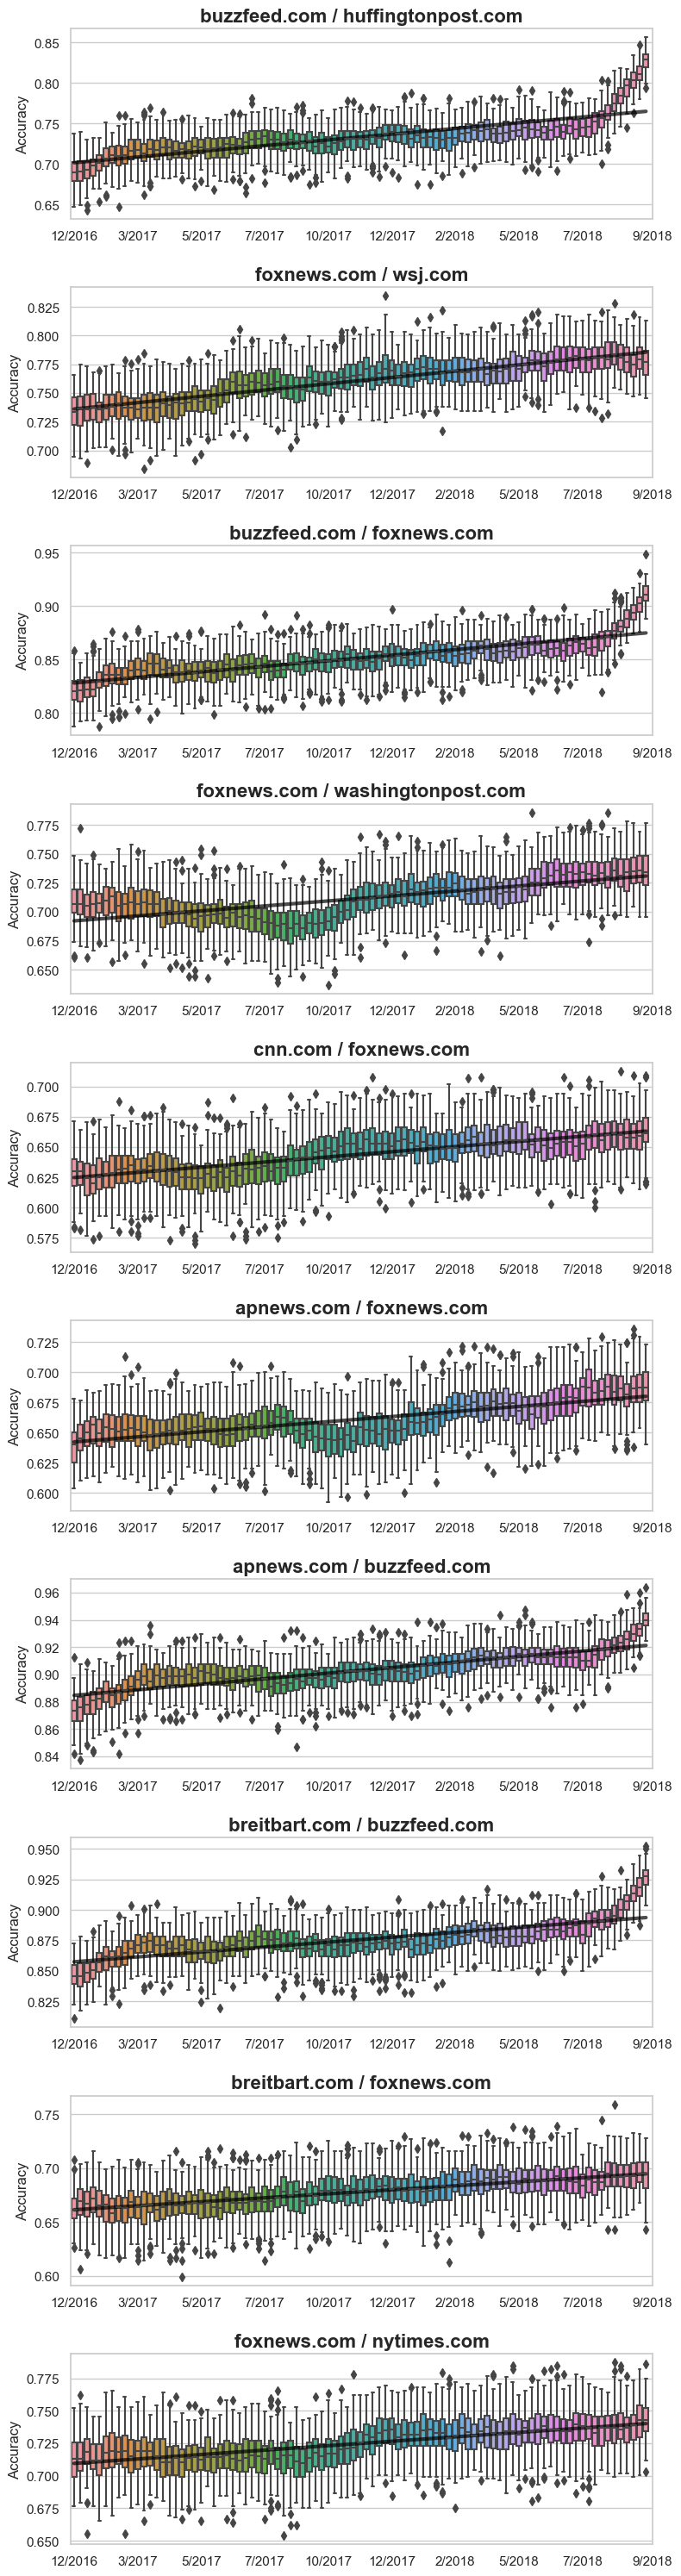

In [15]:
plot_pairs(lr_df.sort_values('slope', ascending=False).head(10), 'figures/ts-ab-rising.png')

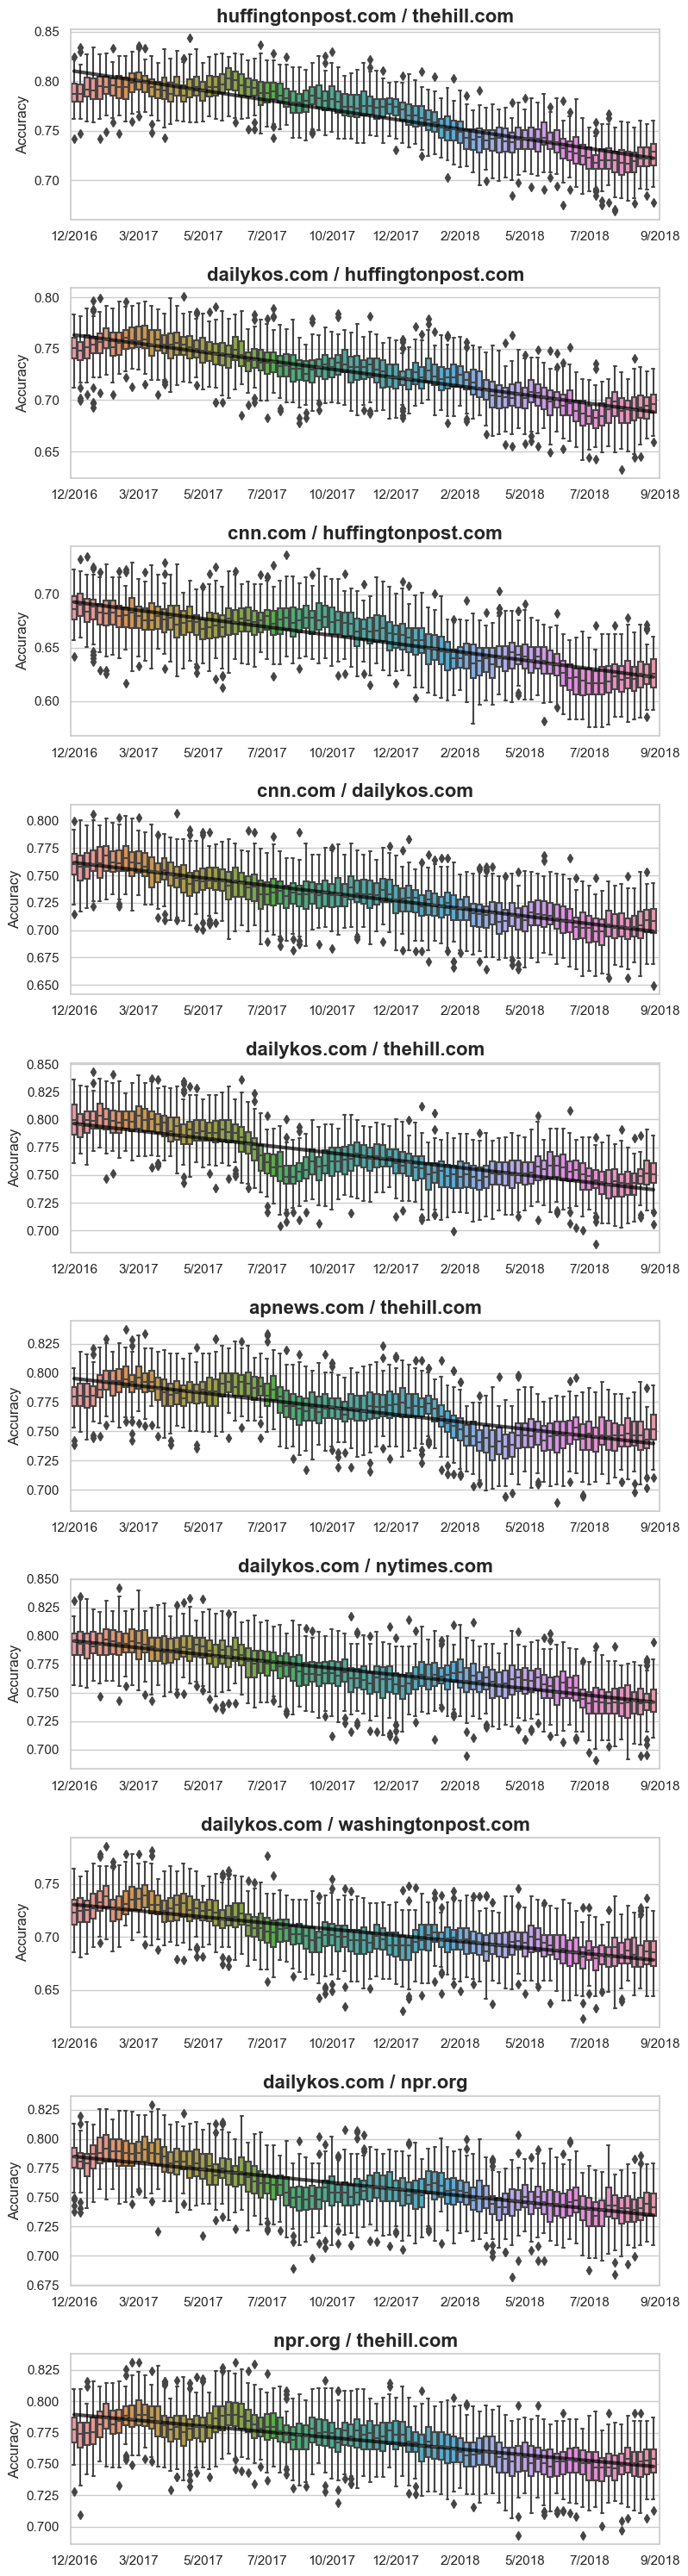

In [16]:
plot_pairs(lr_df.sort_values('slope', ascending=True).head(10), 'figures/ts-ab-falling.png')

In [17]:
lr_df['label'] = lr_df[['d1', 'd2']].apply(lambda x: f'{x[0]} - {x[1]}', axis=1)

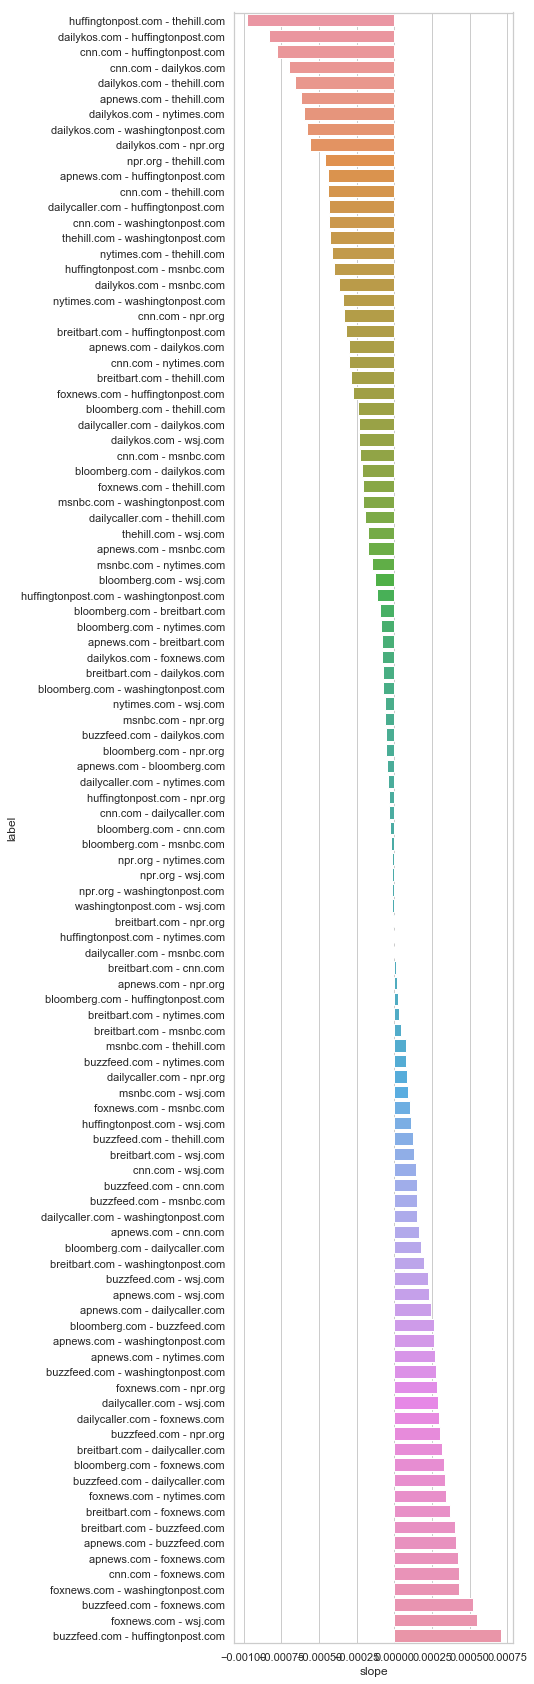

In [18]:
plt.figure(figsize=(5,30))
sns.barplot(x='slope', y='label', data=lr_df.sort_values('slope'))

In [72]:
lr_df['color'] = lr_df.slope.apply(lambda s: 'red' if s > 0 else 'blue')
lr_df['width'] = preprocessing.minmax_scale(abs(lr_df.slope), (0,3)) ** 2

In [73]:
g = nx.Graph()
for r in lr_df.sort_values('slope').itertuples():
    g.add_edge(r.d1, r.d2, width=r.width, color=r.color)

In [74]:
edge_width = [d['width'] for _, _, d in g.edges(data=True)]
edge_color = [d['color'] for _, _, d in g.edges(data=True)]

/Users/dclure/.local/share/virtualenvs/news-vec-AvAtlVxK/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


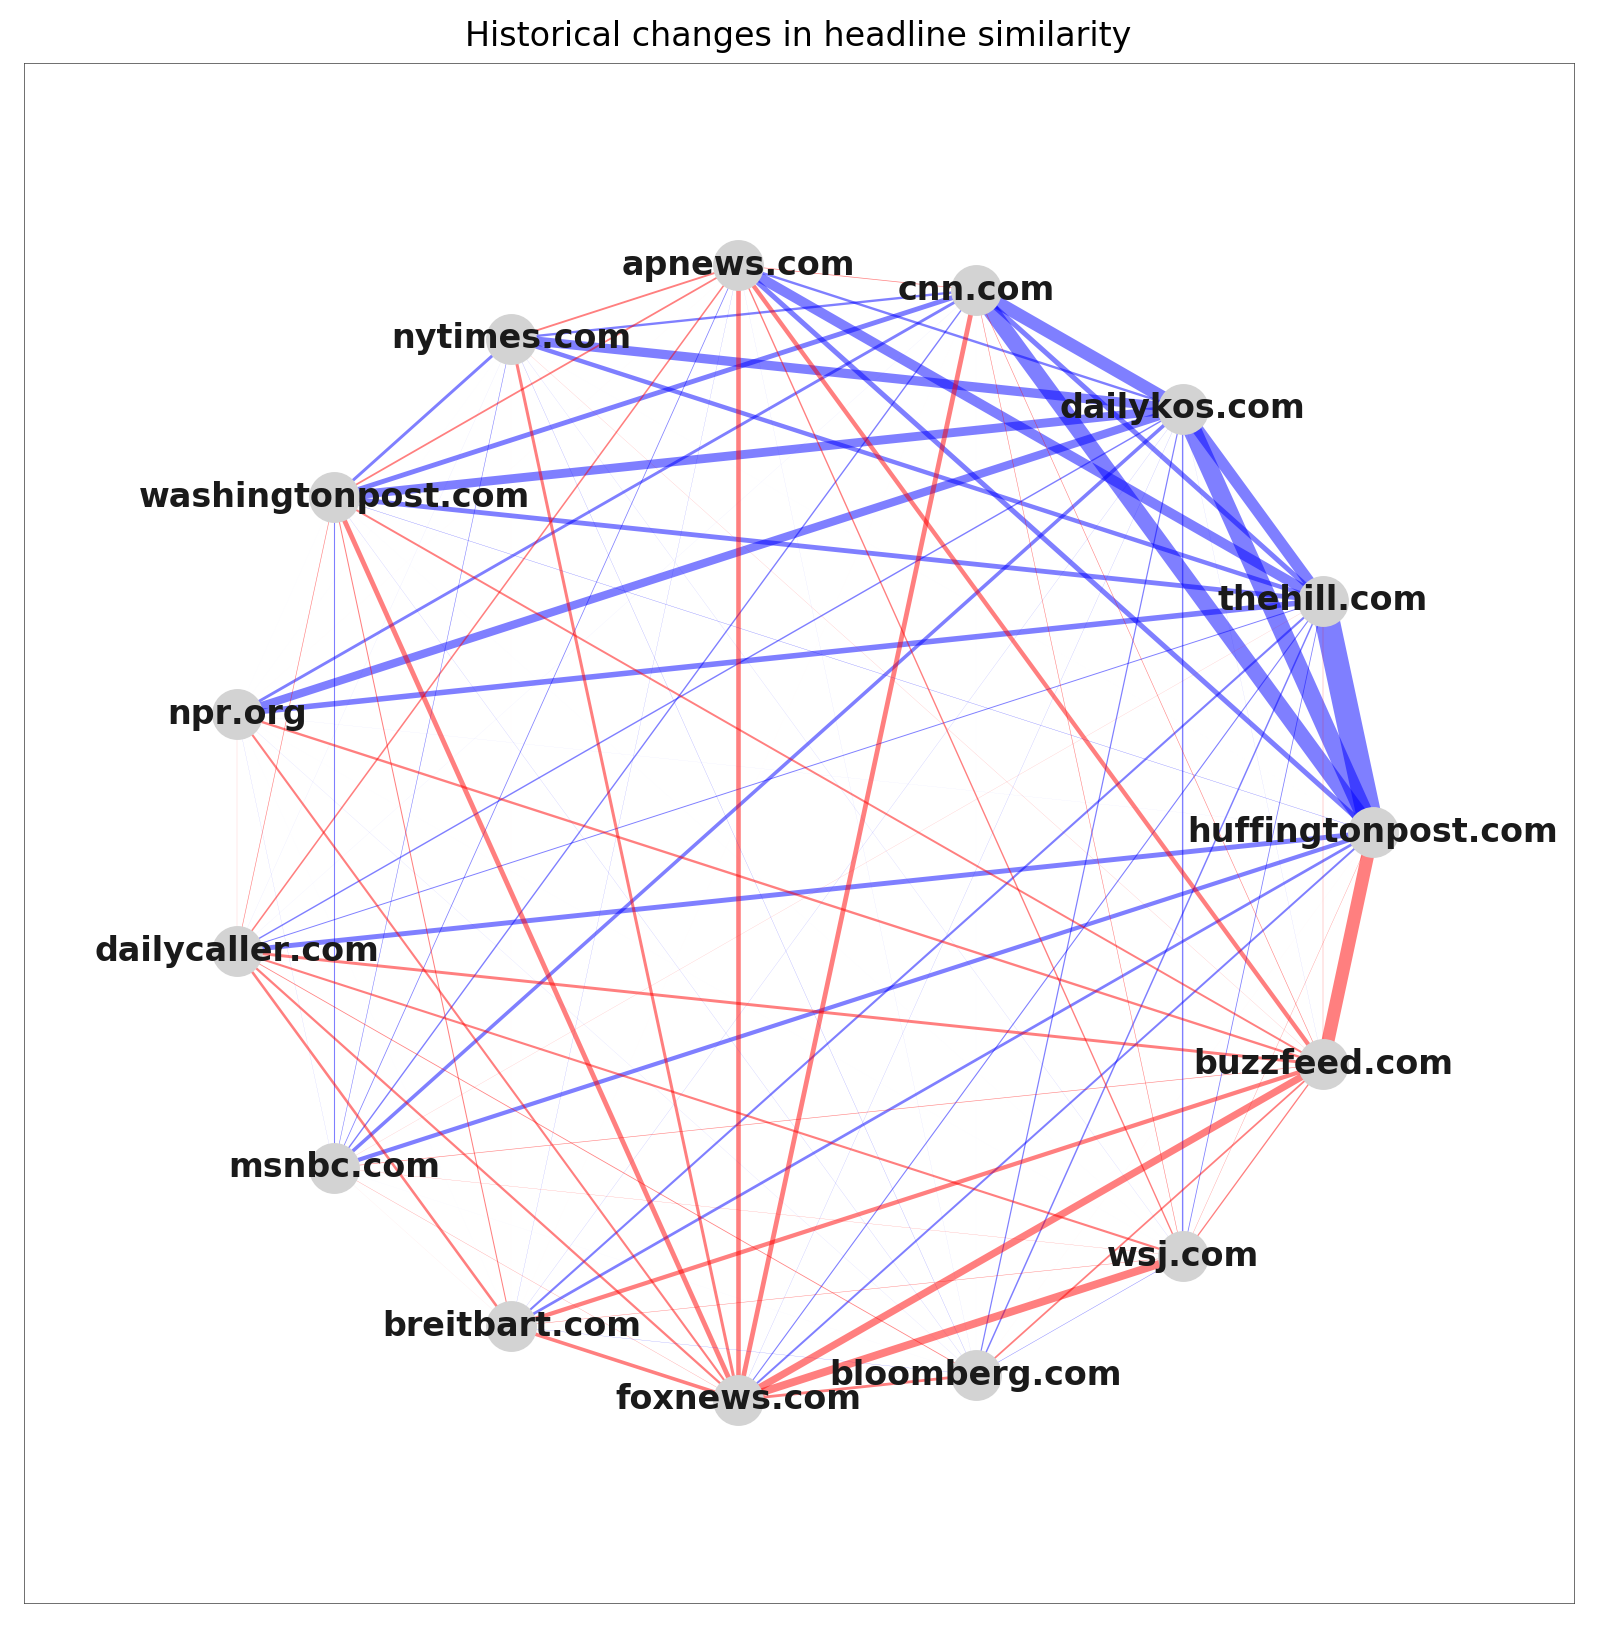

In [75]:
mpl.style.use('default')
plt.figure(figsize=(10,10), dpi=200)
mpl.rc('axes', linewidth=0.2)
plt.xlim(-1.35,1.35)
plt.ylim(-1.35,1.35)
plt.xticks([])
plt.yticks([])
plt.title('Historical changes in headline similarity')

pos = nx.layout.circular_layout(g)
nx.draw_networkx_nodes(g, pos, node_color='lightgray')
nx.draw_networkx_edges(g, pos, edge_color=edge_color, width=edge_width, alpha=0.5)
_ = nx.draw_networkx_labels(g, pos, font_weight='bold')

plt.savefig('figures/ts-ab-radial.png', bbox_inches='tight')

In [71]:
lr_df.to_json('data/ts-ab-lr.json', orient='records', lines=True)

In [7]:
pred_df, embeds = read_preds('../../data/ava-cnn/')

100%|██████████| 284/284 [00:15<00:00, 18.25it/s]


In [8]:
pred_df['tokens_key'] = pred_df.clf_tokens.apply(lambda ts: tuple(ts))

In [9]:
pred_df = pred_df.drop_duplicates('tokens_key', keep=False)

In [10]:
pred_df_start = pred_df[pred_df.windows.apply(lambda ws: any(np.array(ws) < 10))]
pred_df_end = pred_df[pred_df.windows.apply(lambda ws: any(np.array(ws) > 80))]

In [11]:
idx_start = AnnoyIndex(embeds.shape[1])
for i in tqdm(pred_df_start.index):
    idx_start.add_item(i, embeds[i])
    
idx_end = AnnoyIndex(embeds.shape[1])
for i in tqdm(pred_df_end.index):
    idx_end.add_item(i, embeds[i])

100%|██████████| 49565/49565 [00:03<00:00, 12978.83it/s]


In [12]:
idx_start.build(20)
idx_end.build(20)

True

In [13]:
def delta_hls(df1, df2, idx, domain=None, n=20, probe=10000):
    
    v1 = embeds[df1.index].mean(0)
    v2 = embeds[df2.index].mean(0)

    matches = 0
    for i in idx.get_nns_by_vector(v2-v1, probe):
        
        r = pred_df.loc[i]
        
        if not domain or r.domain == domain:
            print(r.title)
            matches += 1
            if matches == n:
                break

# Buzzfeed

In [14]:
delta_hls(
    pred_df_start[pred_df_start.domain=='buzzfeed.com'],
    pred_df_end[pred_df_end.domain=='buzzfeed.com'],
    idx_end,
    'buzzfeed.com',
)

Build A Trendy Hipster Meal And We 'll Tell You Which YA Heroine You Are
Write A Love Letter And We 'll Tell You Which " To All The Boys " Character You 're Compatible With
Eat A Bunch Of Food And We 'll Tell You Which " SpongeBob " Character You Are
Rate These Movie Theater Snacks And We 'll Reveal If You 'd Survive In A Slasher Film
Make A Break Up Playlist And We 'll Tell You Which Marvel Superhero You 're Most Compatible With
Pick Some Colored Shirts And We 'll Reveal Which " The Breakfast Club " Character You 're Most Like
Make A Breakup Playlist And We 'll Tell You Which Marvel Superhero You 're Most Compatible With
Pick Your First Day Of School Outfit And We 'll Tell You If You 're A Freshman , Sophomore , Junior , Or Senior
Order Some McDonald 's , And We 'll Reveal Whether Your Soulmate Is More Like Jamey Or Peter Kavinsky
Choose Between These Gucci Items And We 'll Tell You Which Disney Princess You Are
See A Movie At The Premiere And We 'll Tell You If You 're More Drake Or 

In [15]:
delta_hls(
    pred_df_end[pred_df_end.domain=='buzzfeed.com'],
    pred_df_start[pred_df_start.domain=='buzzfeed.com'],
    idx_start,
    'buzzfeed.com',
)

Dakota Access Pipeline Challengers Race To Court To Block Construction
Trump Vineyard Seeks More Foreign Workers
Trump Begins Rolling Back Major Obama Water Pollution Rule
Trump Wrote Iraq WMDs Were Threat Year Before Bush Took Office
Trump Winery Seeks Even More Foreign Workers
Alongside Trump , Intel Reannounces Arizona Factory
Trump Moves To Challenge Vaccine Science
Trump Gets Anonymity After Dissing Anonymous Sources
With Tough Re Elections Looming , Democrats Plot Confirmation Hearing Strategy
EPA 's Science Panel Might Soon Be Stacked With Polluters
Tom Steyer Moves Beyond Climate
Guardian Ditches Move To Kushner Building After Newsroom Revolt
NAACP Leaders : Romney Ca n't Connect With Black Audiences
Pentagon " Presenting Options " For Military Action In Syria
20th Century Fox Optioned Bill O'Reilly WWII Book Months Before His Exit
Employers Abuse Foreign Workers . U.S. Says , By All Means , Hire More .
Trump Says Post Crisis Financial Rules Will Be Cut Back
Democrats Confront 

# Fox

In [16]:
delta_hls(
    pred_df_start[pred_df_start.domain=='foxnews.com'],
    pred_df_end[pred_df_end.domain=='foxnews.com'],
    idx_end,
    'foxnews.com',
)

Florida female felon 's bloody mugshot the result of her head on crash while fleeing cops , officials say
SC woman allegedly told cops she 's a ' clean , thoroughbred , white girl ' after being pulled over : report
Jefferson Airplane singer Marty Balin sues hospital , claiming he lost part of his tongue after botched tracheotomy
' Smallville ' actress Allison Mack asks court to let her continue acting amid NXIVM sex cult allegations
Charlie Sheen claims he ca n't afford child support after being ' blacklisted ' in Hollywood , says report
Gunman shot by Florida armed bystander still hospitalized , NRA says shooting example of ' good guy with a gun '
' The Wire ' creator David Simon reveals in profanity laced post that he was banned from Twitter after wishing death on Trump supporter
World renowned lesbian NYU professor suspended after probe finds she sexually harassed gay male student , report says
Carter Page was ' more like Inspector Gadget than Jason Bourne , ' Gowdy says amid FISA r

In [17]:
delta_hls(
    pred_df_end[pred_df_end.domain=='foxnews.com'],
    pred_df_start[pred_df_start.domain=='foxnews.com'],
    idx_start,
    'foxnews.com',
)

Trump : No plans to fill ' unnecessary ' appointed positions
Teachers Unions In A Panic Over School Choice
Best job search websites
' Bikepacking ' adds a dose of fun to backpacking
Fox News Poll : Fewer fret over , more focus on politics
Eurozone growth edging higher at the start of second quarter
Is health care a right ?
Five reasons not to observe Lent
Governor of Puerto Rico on debt crisis , push to become state
North Korea : A rare look inside an insulated yet menacing country
Mosquitoes and ticks are coming for us all this summer
Is whiskey becoming less popular ?
CEO gives job applicants a ' snowflake test '
Reformist head of Ukraine 's central bank resigns
Is Zika still a concern ?
OPINION : One Way or Another , Confirm Judge Gorsuch
Trump Starts Over With Tax Plan : Report
Who runs the world ?
Stock it or skip it ? How to cut grocery costs
Agriculture nominee will distance himself from businesses


# NPR -> DK

In [22]:
delta_hls(
    pred_df_start[pred_df_start.domain=='dailykos.com'],
    pred_df_end[pred_df_end.domain=='dailykos.com'],
    idx_end,
    'dailykos.com',
)

U.S. Forces Sodomized Prisoners at Bagram with Sticks
Michigan health director to stand trial for manslaughter in Flint water related deaths
Old man shakes fist at cloud , yells : ' FAIR TRADE ! '
Morning Digest : Prosecutor says she dropped charges against Greitens in exchange for resignation
' Rhino poachers ' eaten by lions on game reserve in South Africa
Open thread for night owls : Loss of gene puts marine mammals at risk from organophosphate pesticides
Freed from death row : Sabrina Butler Smith 's story — Disrespectability Politics Season 2 , Ep . 6
This week in the war on workers : California court cracks down on widespread wage theft
Abbreviated Science Round up : Selling fossils , lizard origins , probiotic flies
Midday open thread : Ozone eating chemical makers revealed ; arms race in space
Midday open thread : Primary night , pot beer , and dead fish
Morning Digest : Blue Dog Ed Case mounts unexpected comeback in Hawaii
Wyoming to decide whether to allow Yellowstone region 

In [21]:
delta_hls(
    pred_df_end[pred_df_end.domain=='nytimes.com'],
    pred_df_start[pred_df_start.domain=='nytimes.com'],
    idx_start,
    'nytimes.com',
)

New Jersey Towns ' Efforts to Shirk Housing Obligations
Fighting Compulsive Gambling Among Women
August Wilson 's ' Jitney ' at Manhattan Theater Club
' Spamilton ' Moving to Midtown
Today in Small Business : Weather !
Simon Spurr Returns to Fashion
Civil Lawsuit With Seller of Foreclosed Homes
Neiman Marcus Exploring Options , Including Potential Sale
On Banning on Leaf Blowers
From ' Camp David ' to ' Oslo , ' Forging Drama from Diplomacy
Student 's Arrest Tests Immigration Policy
Avian Housing Wars : Competition for Nesting Spots
From Cobb to Cubs :
' Star Trek ' Copyright Settlement Allows Fan Film to Proceed
Hugh Hardy 's Tow Theater at Lincoln Center
Expert Opinion or Elaborate Ruse ? Scrutiny for Scholars ' Role in Art Sales
Adventures in Space : New Carry On Rules
Opinion | Sentenced to Be Crucified
Kathryn Johnson , Lee Rosenthal
New York Today : Complaints of Dirty Streets
